In [1]:
pip install SALib

     |████████████████████████████████| 860kB 2.7MB/s 
  Created wheel for SALib: filename=SALib-1.3.11-py2.py3-none-any.whl size=729665 sha256=6158f0a95bbab78e8226a8bae6b56a29b3bd838f24bf9dbc1b67a405159e8859
  Stored in directory: /root/.cache/pip/wheels/62/ed/f9/a0b98754ffb2191b98324b96cbbeb1bd5d9598b39ab996b429
Successfully built SALib


In [14]:
import sys

from SALib.sample import saltelli,finite_diff, fast_sampler
from SALib.analyze import morris,sobol, dgsm, fast, delta
from SALib.util import read_param_file
from SALib.sample.morris import sample
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, sample_histograms

import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv2D, Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
import keras
import pandas
import math
from sklearn.metrics import mean_squared_error,f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc
import copy
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import os
import pandas as pd

import sys
import matplotlib.pyplot as plt
hgroup= 2
if (len(sys.argv)>1):
    hgroup = sys.argv[1]
    

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_path = "/content/drive/My Drive/SA/data"

In [16]:
feature_labels = np.load(os.path.join(data_path, "featurelabels_v7.npy"), fix_imports=True, encoding='latin1')[1:]
clf = keras.models.load_model(os.path.join(data_path, 'dnn_v1_hgroup_2.h5'))
realnames = np.load(os.path.join(data_path, "featurelabels_real.npy"),allow_pickle = True, fix_imports=True,encoding='latin1').item()

In [17]:
feature_labels_new=[]
for f in feature_labels:
    f = f.decode('utf-8')
    if (f in realnames.keys()):
        rn = realnames[f].replace(" ", "_")
        feature_labels_new.append(rn)
    else:
        feature_labels_new.append(f.replace(" ", "_"))


In [18]:
problem = {
  'num_vars': 369,
  'names': list(feature_labels_new),
  'bounds': [[0.0, 1.0]]*369 #standard scaled
}

In [19]:
## 1- Morris
from SALib.analyze import morris
from SALib.sample.morris import sample
X = sample(problem, N=10, num_levels=4, optimal_trajectories=None)

Y = clf.predict(X)
Y = np.nan_to_num(Y).flatten()


si_morris = morris.analyze(problem, X, Y, conf_level=0.95, 
                    print_to_console=False,
                    num_levels=4, num_resamples=100)

In [20]:
si_morris.keys()

dict_keys(['names', 'mu', 'mu_star', 'sigma', 'mu_star_conf'])

In [21]:
## 2- Sobol
from SALib.sample import saltelli
from SALib.analyze import sobol

X = saltelli.sample(problem, 10, calc_second_order=True)
Y = clf.predict(X)
Y = np.nan_to_num(Y).flatten()

si_sobol = sobol.analyze(problem, Y, print_to_console=False)

In [ ]:
si_sobol.keys()

dict_keys(['S1', 'S1_conf', 'ST', 'ST_conf', 'S2', 'S2_conf'])

In [23]:
def _sort_Si(Si, key, sortby):
    return np.array([Si[key][x] for x in np.argsort(Si[sortby])])


In [24]:
#---Si_sobol plot

Si_key = {k:si_sobol[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_key, index=problem['names'])

Si_df['names']=problem['names']

sortcol = 'S1'
names_sorted1 = _sort_Si(Si_df, 'names',sortcol)
val_sorted = _sort_Si(Si_df, 'S1', sortcol)
err_sorted = _sort_Si(Si_df, 'S1_conf', sortcol)


sortcol = 'ST'
names_sorted2 = _sort_Si(Si_df, 'names',sortcol)
val2_sorted = _sort_Si(Si_df, 'ST', sortcol)
err2_sorted = _sort_Si(Si_df, 'ST_conf', sortcol)


fig, ax = plt.subplots(1,2,figsize=(60,150))
# plt.xlim([-0.5,0.5])
# fig.set_size_inches(2,150)


y_pos = np.arange(len(val_sorted))
plot_names = names_sorted1

ax[0].barh(y_pos,
              val_sorted,
              xerr=err_sorted,
              align='center',
              ecolor='black')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(plot_names)
ax[0].set_xlabel('S1')
ax[0].set_ylim(min(y_pos)-1, max(y_pos)+1)

y_pos = np.arange(len(val_sorted))
plot_names = names_sorted2

ax[1].barh(y_pos,
              val2_sorted,
              xerr=err2_sorted,
              align='center',
              ecolor='black')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(plot_names)
ax[1].set_xlabel('ST')
ax[1].set_ylim(min(y_pos)-1, max(y_pos)+1)


plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
### 3- Derivative-based Global Sensitivity Measure (DGSM)
from SALib.sample import finite_diff
from SALib.analyze import dgsm
param_values = finite_diff.sample(problem, 10, delta=0.001)
Y = clf.predict(param_values)
Y = np.nan_to_num(Y).flatten()

Si_dgsm = dgsm.analyze(problem, param_values, Y, num_resamples=1000, conf_level=0.95, print_to_console=False)
# np.save('dgsm_analysis_'+str(hgroup)+'.npy', Si_dgsm) 


In [ ]:
Si_dgsm.keys()

dict_keys(['vi', 'vi_std', 'dgsm', 'dgsm_conf', 'names'])

In [ ]:
### 4- FAST - Fourier Amplitude Sensitivity Test
from SALib.sample import fast_sampler
from SALib.analyze import fast

param_values = fast_sampler.sample(problem,1000)
Y = clf.predict(param_values)
Y = np.nan_to_num(Y).flatten()
Si_fast = fast.analyze(problem, Y, print_to_console=False)

In [ ]:
Si_fast.keys()

dict_keys(['S1', 'ST', 'names'])

In [ ]:
#### 5- RBD-FAST - Random Balance Designs Fourier Amplitude Sensitivity Test
from SALib.sample import latin
from SALib.analyze import rbd_fast
X = latin.sample(problem,10)
Y = clf.predict(X)
Y = np.nan_to_num(Y).flatten()
Si_rbd = rbd_fast.analyze(problem,X, Y, print_to_console=False)

In [ ]:
Si_rbd.keys()

dict_keys(['delta', 'delta_conf', 'S1', 'S1_conf', 'names'])

In [10]:
#### 6- Delta Moment-Independent Measure
from SALib.sample import latin
from SALib.analyze import delta
X = latin.sample(problem,10)
Y = clf.predict(X)
Y = np.nan_to_num(Y).flatten()
Si_delta = delta.analyze(problem,X, Y, print_to_console=False)

In [11]:
Si_delta.keys()

dict_keys(['delta', 'delta_conf', 'S1', 'S1_conf', 'names'])

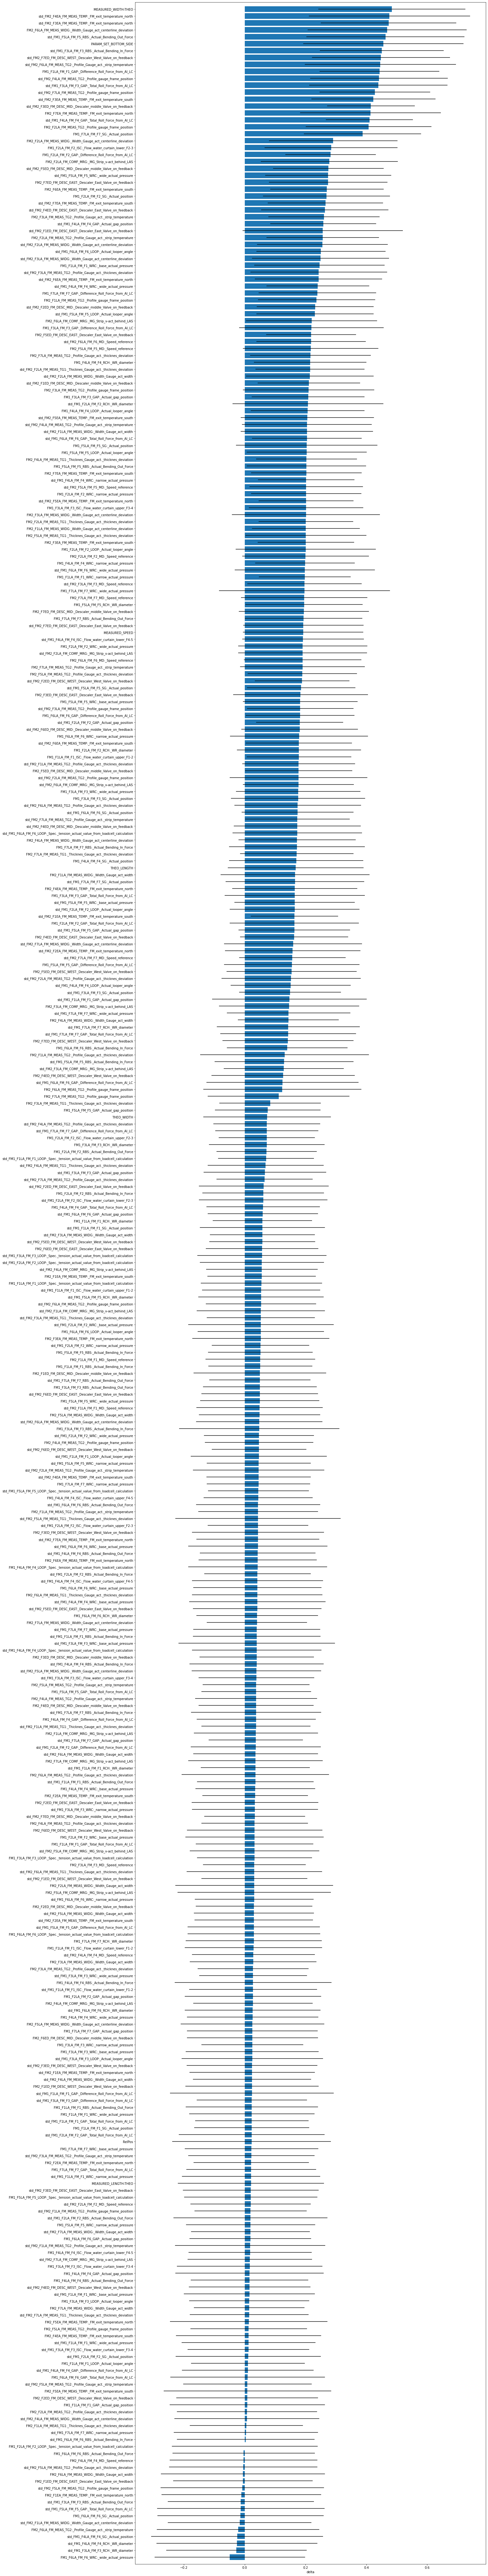

In [26]:
#---Si_delta plot

Si_key = {k:Si_delta[k] for k in ['delta', 'delta_conf', 'S1', 'S1_conf']}
Si_df = pd.DataFrame(Si_key, index=problem['names'])

Si_df['names']=problem['names']

sortcol = 'delta'
names_sorted = _sort_Si(Si_df, 'names',sortcol)
val_sorted = _sort_Si(Si_df, 'delta', sortcol)
err_sorted = _sort_Si(Si_df, 'delta_conf', sortcol)


sortcol = 'S1'
names_sorted = _sort_Si(Si_df, 'names',sortcol)
val2_sorted = _sort_Si(Si_df, 'S1', sortcol)
err2_sorted = _sort_Si(Si_df, 'S1_conf', sortcol)


fig, ax = plt.subplots(1,1,figsize=(20,150),sharey=True)
# plt.xlim([-0.5,0.5])
# fig.set_size_inches(2,150)


y_pos = np.arange(len(val_sorted))
plot_names = names_sorted

ax.barh(y_pos,
              val_sorted,
              xerr=err_sorted,
              align='center',
              ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_names)
ax.set_xlabel('delta')
ax.set_ylim(min(y_pos)-1, max(y_pos)+1)

y_pos = np.arange(len(val_sorted))

# ax[1].barh(y_pos,
#               val2_sorted,
#               xerr=err2_sorted,
#               align='center',
#               ecolor='black')
# ax[1].set_yticks(y_pos)
# ax[1].set_yticklabels(plot_names)
# ax[1].set_xlabel('S1')
# ax[1].set_ylim(min(y_pos)-1, max(y_pos)+1)

plt.show()


In [ ]:
#### 7- Fractional Factorial
# from SALib.sample.ff import sample
# from SALib.analyze.ff import analyze
# X = sample(problem)
# Y = clf.predict(X)
# Y = np.nan_to_num(Y).flatten()
# Si_ff = analyze(problem,X, Y, second_order=True,print_to_console=True)

PLOTS

In [ ]:
# fig, ax1 = plt.subplots(1,1,figsize=(20,10))
# for i,n in enumerate(si_dgsm.keys()):
#   plt.bar(n)


fig, ax = plt.subplots(1,6, figsize=(40,8) , sharey=True)
for i, n in enumerate(Si_dgsm.keys()):
    y = np.nan_to_num(Si_dgsm[n])
    ax[i].barh(y, 10)
    ax[i].set_xlabel(n)
ax[0].set_ylabel('dgsm sensitivity')

fig.set_size_inches(10,4)
fig.subplots_adjust(wspace=0.1)

plt.show()

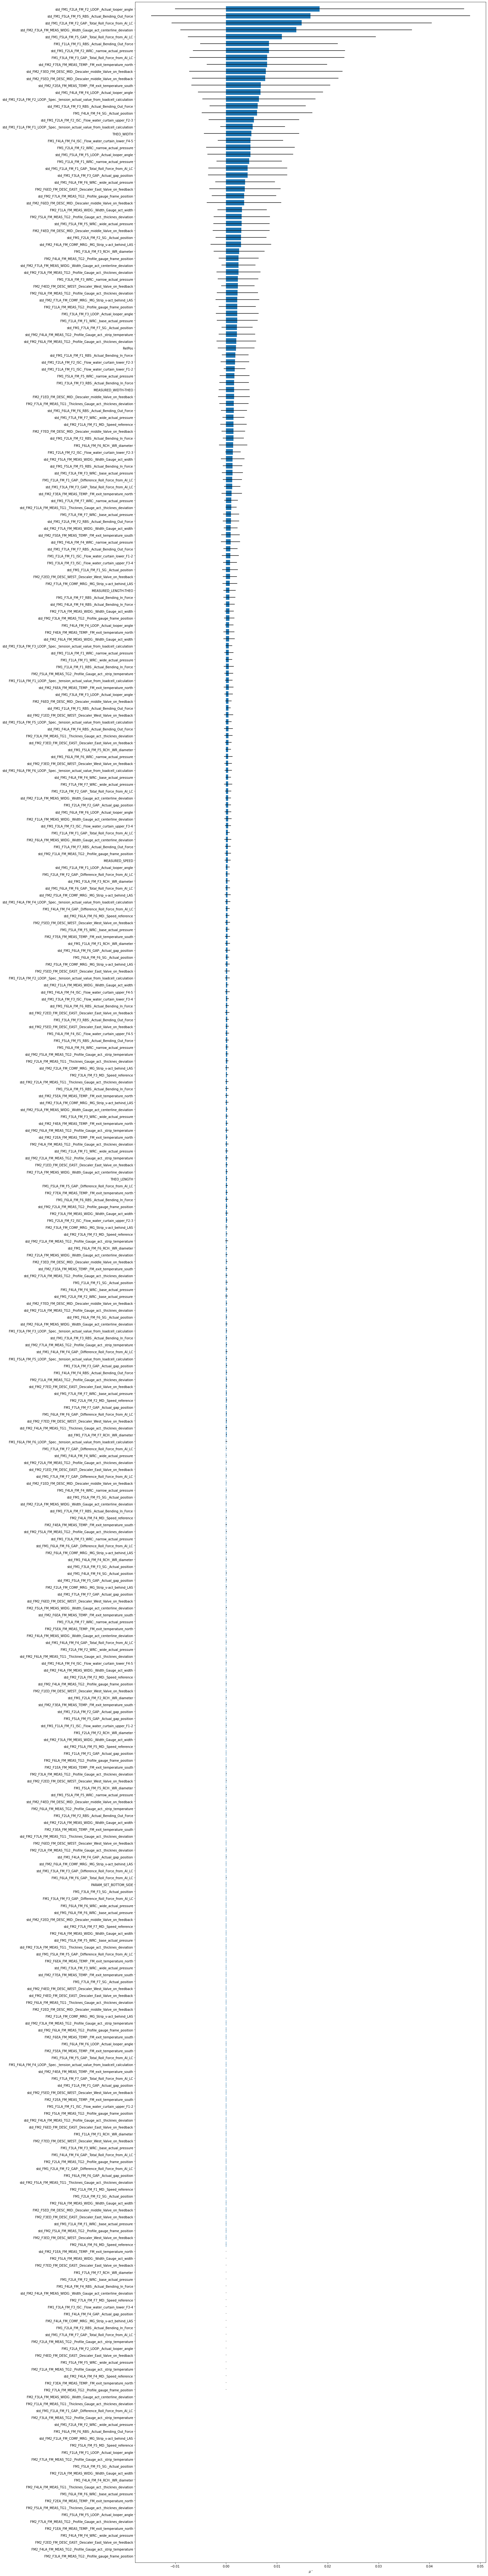

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize=(20,150))

p = horizontal_bar_plot(ax1,si_morris,{})
# set plot style etc.

# fig, ax = plt.subplots(1, 1)
# my_plotter(ax, data1, data2, {'marker':'x'})

# p.show()

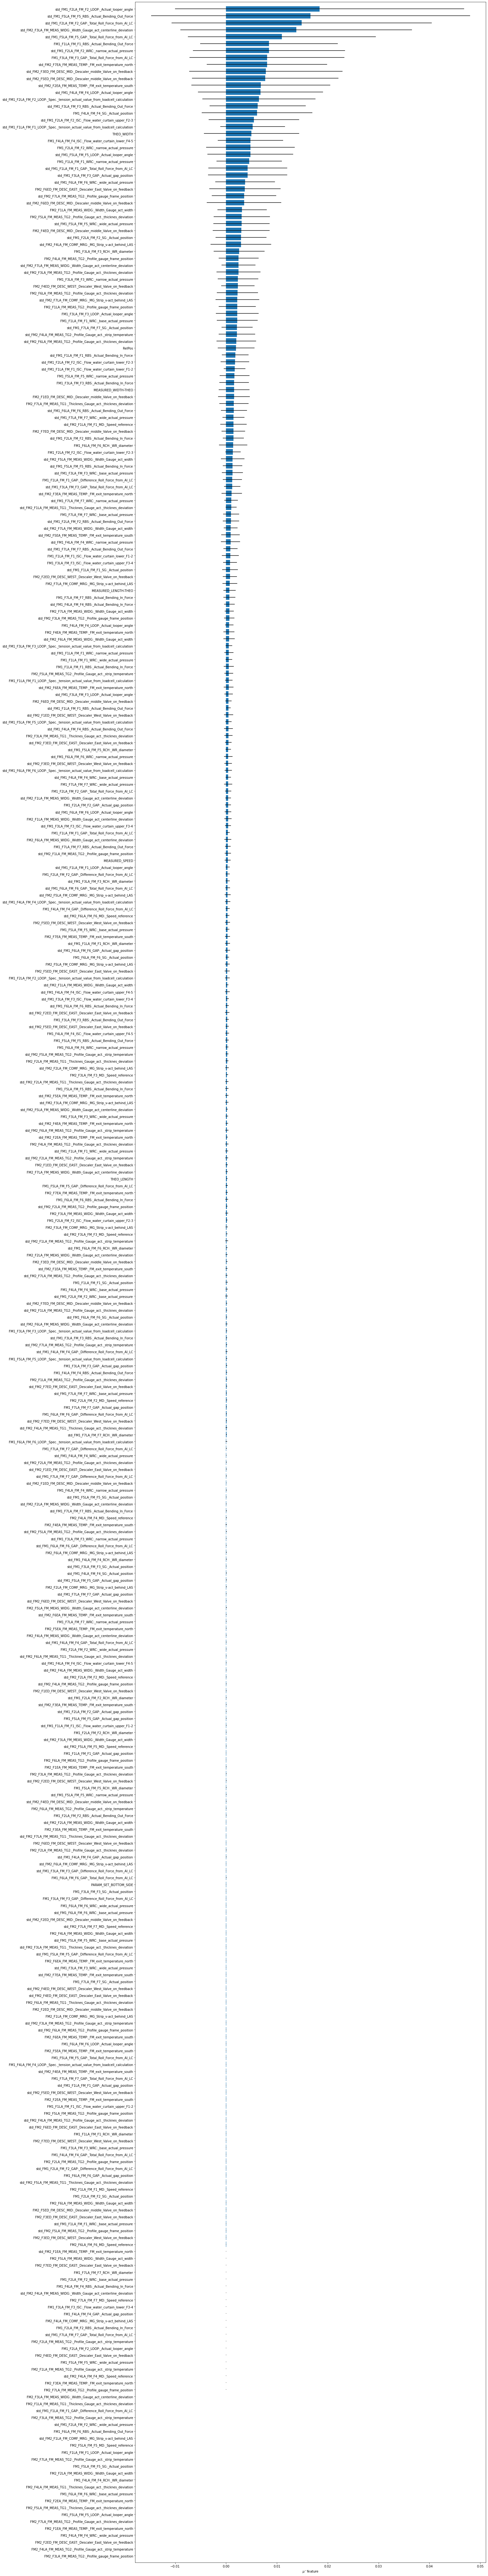

In [ ]:
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, \
    sample_histograms
    
fig, (ax) = plt.subplots(1, 1,figsize=(20,150))

horizontal_bar_plot(ax, si_morris, {}, sortby='mu_star', unit=r"feature")


plt.show()

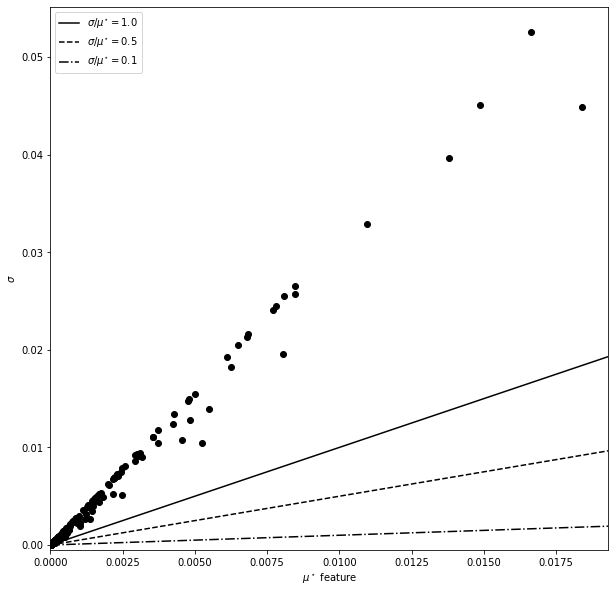

In [ ]:
fig, (ax) = plt.subplots(1, 1,figsize=(10,10))

covariance_plot(ax, si_morris, {}, unit=r"feature")

plt.show()

ValueError: ignored

<Figure size 432x288 with 0 Axes>

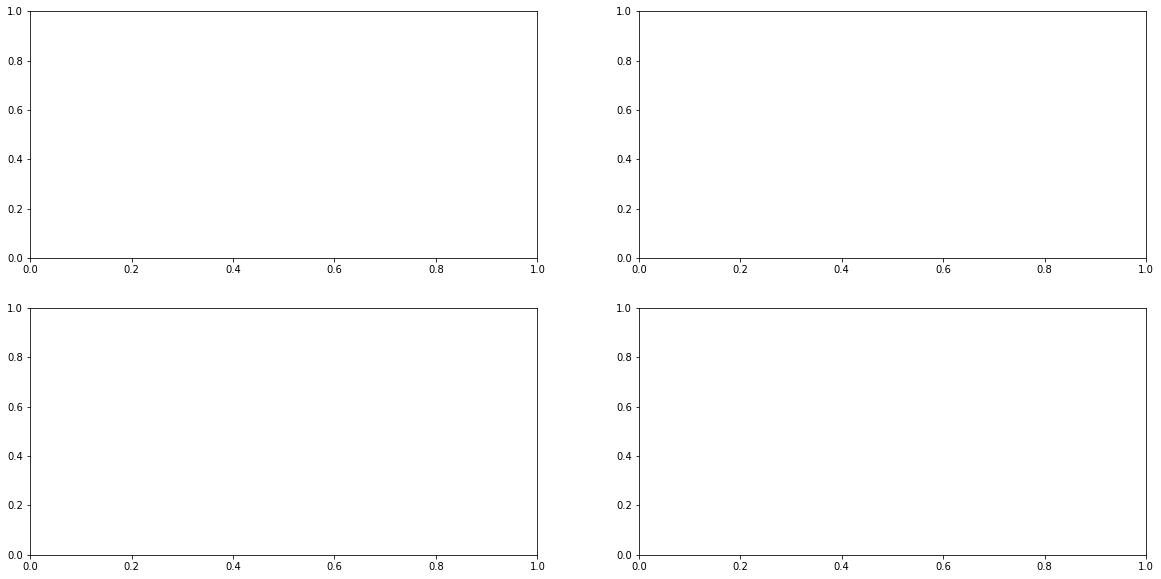

In [ ]:
problem2 = {
  'num_vars': 80,
  'names': list(feature_labels_new[:80]),
  'bounds': [[0.0, 1.0]]*80 #standard scaled
}
fig2 = plt.figure()
plt.subplots(2, 2,figsize=(20,10))
sample_histograms(fig2, X[:,:80], problem2, {'color': 'y'})
plt.show()

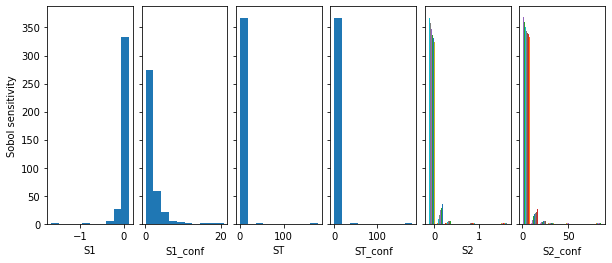

In [ ]:
fig, ax = plt.subplots(1,6, figsize=(40,8) , sharey=True)
for i, n in enumerate(si_sobol.keys()):
    y = np.nan_to_num(si_sobol[n])
    ax[i].hist(y, 10)
    ax[i].set_xlabel(n)
ax[0].set_ylabel('Sobol sensitivity')

fig.set_size_inches(10,4)
fig.subplots_adjust(wspace=0.1)

plt.show()

In [ ]:
from SALib.plotting.bar import plot as barplot
Si_df = si_sobol.to_df()
barplot(Si_df)

TypeError: ignored

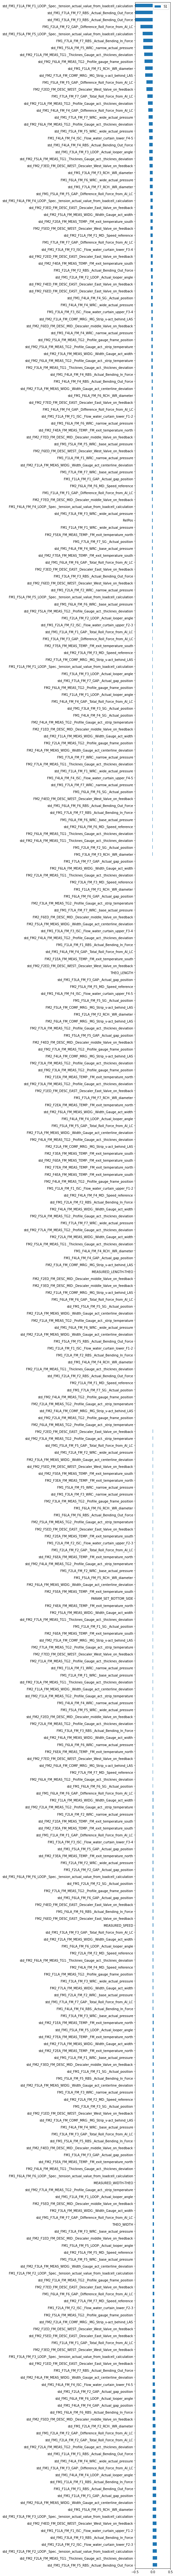

In [ ]:
import pandas as pd
Si_key = {k:si_sobol[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_key, index=problem['names'])


fig, ax = plt.subplots(1,1,sharey=True)
plt.xlim([-0.5,0.5])
fig.set_size_inches(2,150)

#---- Check this!

values = Si_df[['S1']].sort_values(by='S1',ascending = 0)
indices = Si_df[['S1']].sort_index()

#------> add error bar

# err = Si_df[['S1_conf']] ###Si_df needs to be sorted accroding to S1
# values.plot.barh(xerr=err.values.T,ax=ax)
values.plot.barh(ax=ax)


# indices = Si_df[['ST']]
# err = Si_df[['ST_conf']]
# # indices.plot.barh(xerr=err.values.T,ax=ax[1])
# indices.plot.barh(ax=ax[1])

plt.show()

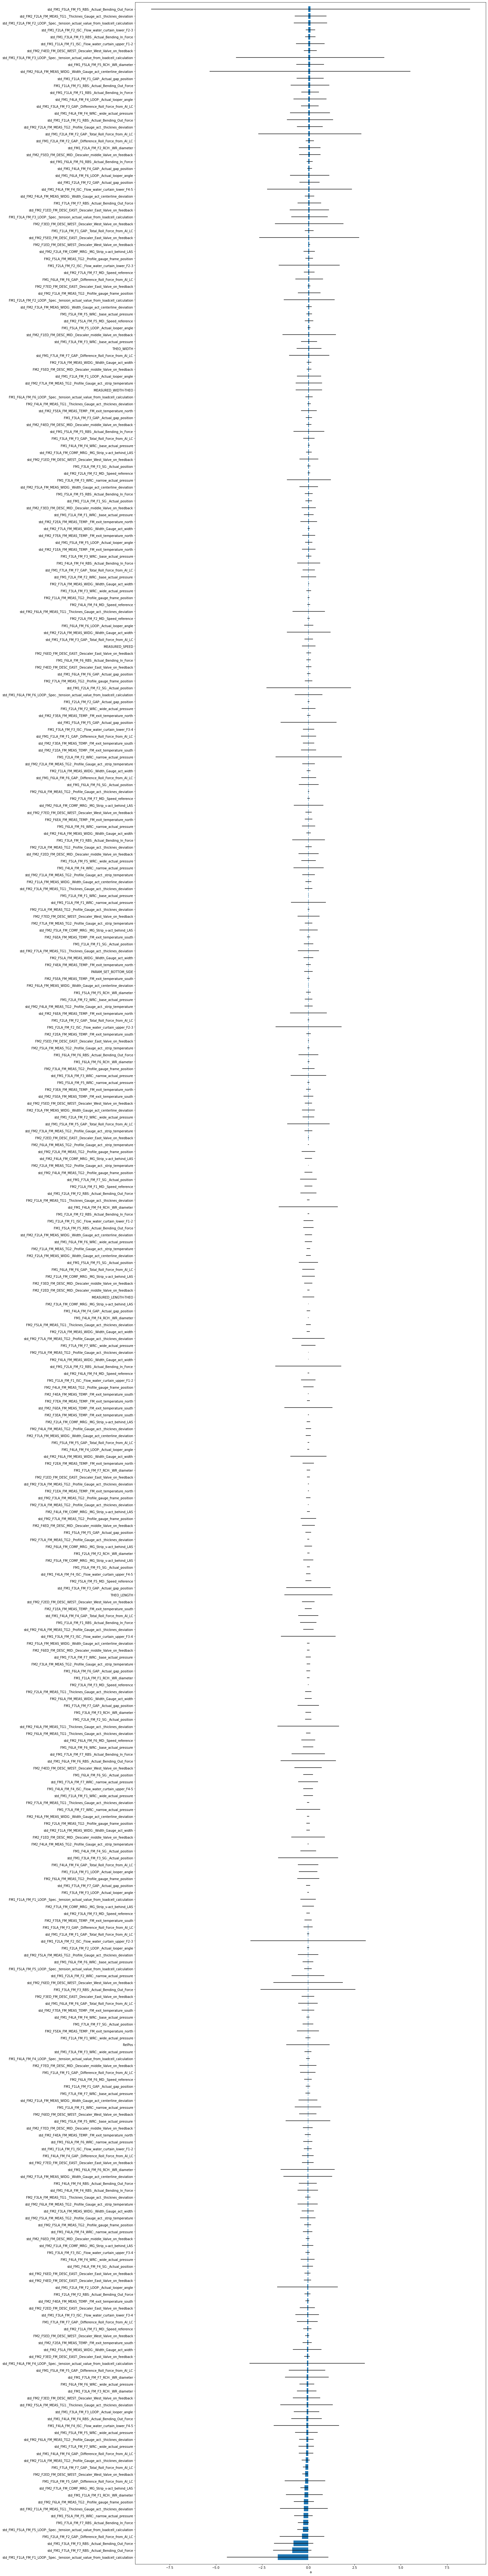

In [ ]:
## yes!
import pandas as pd
import numpy as np


def _sort_Si(Si, key, sortby):
    return np.array([Si[key][x] for x in np.argsort(Si[sortby])])


def _sort_Si_by_index(Si, key, index):
    return np.array([Si[key][x] for x in index])


Si_key = {k:si_sobol[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_key, index=problem['names'])

Si_df['names']=problem['names']

sortcol = 'S1'
names_sorted = _sort_Si(Si_df, 'names',sortcol)
par_sorted = _sort_Si(Si_df, 'S1', sortcol)
err_conf_sorted = _sort_Si(Si_df, 'S1_conf', sortcol)

fig, (ax) = plt.subplots(1, 1,figsize=(20,150))

y_pos = np.arange(len(par_sorted))
plot_names = names_sorted

param_dict={}
out = ax.barh(y_pos,
              par_sorted,
              xerr=err_conf_sorted,
              align='center',
              ecolor='black',
              **param_dict)

ax.set_yticks(y_pos)
ax.set_yticklabels(plot_names)
ax.set_xlabel('S1')

ax.set_ylim(min(y_pos)-1, max(y_pos)+1)
plt.show()

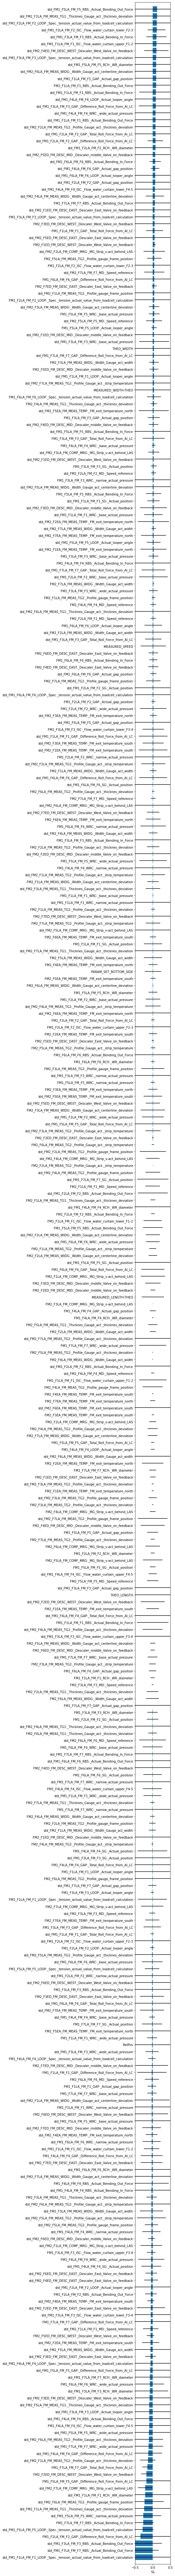

In [ ]:
#---yes yes !
import pandas as pd
import numpy as np


def _sort_Si(Si, key, sortby):
    return np.array([Si[key][x] for x in np.argsort(Si[sortby])])


def _sort_Si_by_index(Si, key, index):
    return np.array([Si[key][x] for x in index])


Si_key = {k:si_sobol[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_key, index=problem['names'])

Si_df['names']=problem['names']

sortcol = 'S1'
names_sorted = _sort_Si(Si_df, 'names',sortcol)
S1_sorted = _sort_Si(Si_df, 'S1', sortcol)
err_confS1_sorted = _sort_Si(Si_df, 'S1_conf', sortcol)


fig, ax = plt.subplots(1,1,sharey=True)
plt.xlim([-0.5,0.5])
fig.set_size_inches(2,150)


y_pos = np.arange(len(S1_sorted))
plot_names = names_sorted


ax.barh(y_pos,
              S1_sorted,
              xerr=err_confS1_sorted,
              align='center',
              ecolor='black')


ax.set_yticks(y_pos)
ax.set_yticklabels(plot_names)
ax.set_xlabel('S1')
ax.set_ylim(min(y_pos)-1, max(y_pos)+1)


plt.show()

In [ ]:
import numpy as np


def _sort_Si(Si, key, sortby='mu_star'):
    return np.array([Si[key][x] for x in np.argsort(Si[sortby])])


def _sort_Si_by_index(Si, key, index):
    return np.array([Si[key][x] for x in index])


def h_bar_plot(ax, Si, param_dict, par, unit=''):
    '''Updates a matplotlib axes instance with a horizontal bar plot
    of mu_star, with error bars representing mu_star_conf
    '''
    sortby=par
    # assert sortby in ['mu_star', 'mu_star_conf', 'sigma', 'mu']

    # Sort all the plotted elements by mu_star (or optionally another
    # metric)
    names_sorted = _sort_Si(Si, 'names', sortby)
    mu_star_sorted = _sort_Si(Si, par, sortby)
    mu_star_conf_sorted = _sort_Si(Si, 'conf', sortby)

    # Plot horizontal barchart
    y_pos = np.arange(len(mu_star_sorted))
    plot_names = names_sorted

    out = ax.barh(y_pos,
                  mu_star_sorted,
                  xerr=mu_star_conf_sorted,
                  align='center',
                  ecolor='black',
                  **param_dict)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(plot_names)
    # ax.set_xlabel(r'$\mu^\star$' + unit)
    ax.set_xlabel('par' + unit)

    ax.set_ylim(min(y_pos)-1, max(y_pos)+1)

    return out


In [ ]:
Si_key = {k:si_sobol[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_key, index=problem['names'])

Si_df['names']=problem['names']

sortcol = 'S1'
names_sorted = _sort_Si(Si_df, 'names',sortcol)
par_sorted = _sort_Si(Si_df, 'S1', sortcol)
err_conf_sorted = _sort_Si(Si_df, 'S1_conf', sortcol)

fig, (ax) = plt.subplots(1, 1,figsize=(20,150))

y_pos = np.arange(len(par_sorted))
plot_names = names_sorted

param_dict={}
out = ax.barh(y_pos,
              par_sorted,
              xerr=err_conf_sorted,
              align='center',
              ecolor='black',
              **param_dict)

ax.set_yticks(y_pos)
ax.set_yticklabels(plot_names)
ax.set_xlabel('S1')

ax.set_ylim(min(y_pos)-1, max(y_pos)+1)
plt.show()

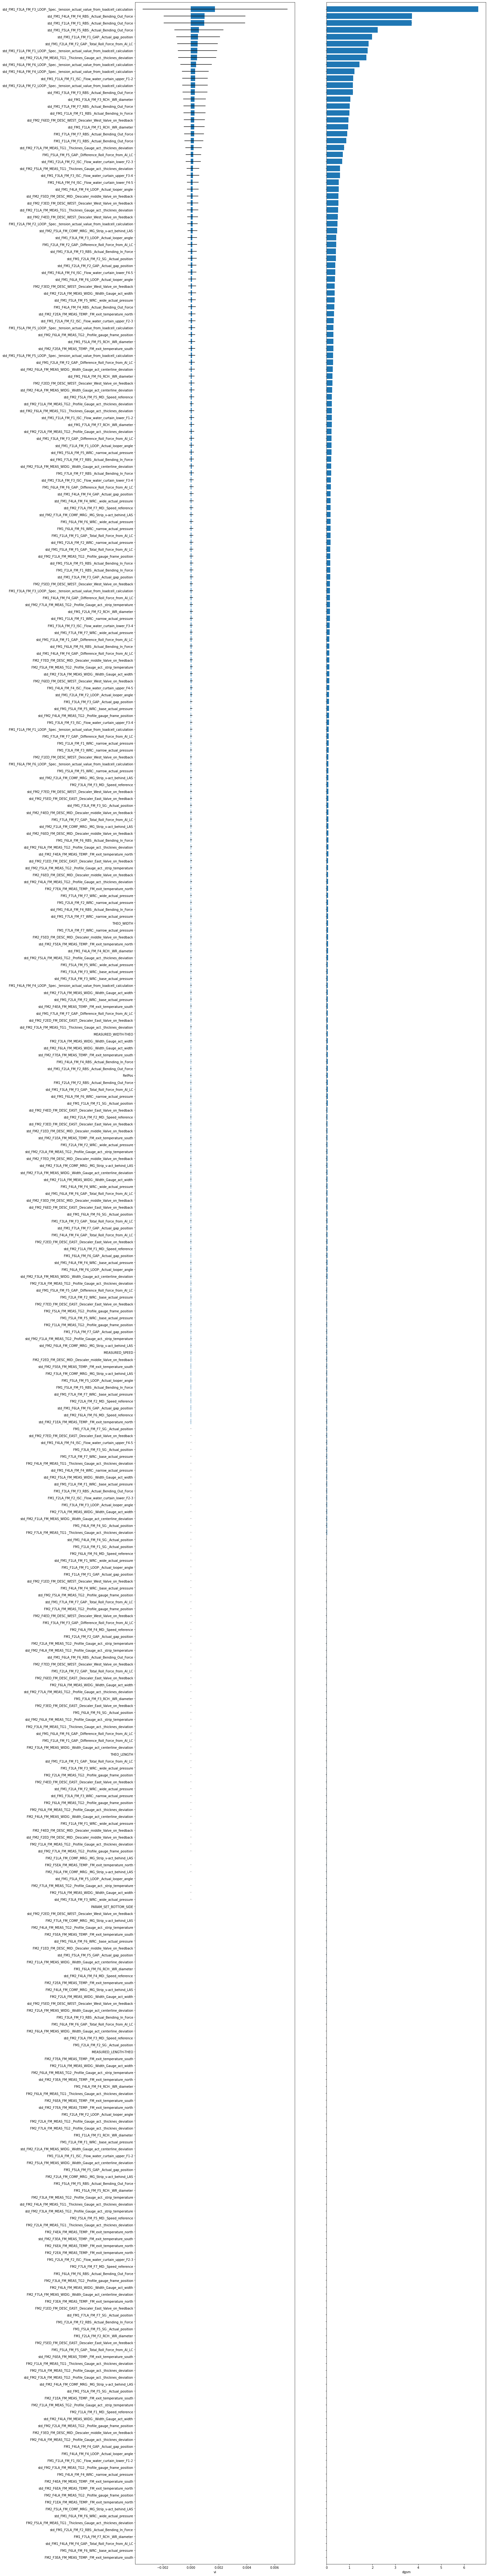

In [ ]:
#---dgsm plot

Si_key = {k:Si_dgsm[k] for k in ['vi','vi_std','dgsm','dgsm_conf']}
Si_df = pd.DataFrame(Si_key, index=problem['names'])

Si_df['names']=problem['names']

sortcol = 'vi'
names_sorted = _sort_Si(Si_df, 'names',sortcol)
val_sorted = _sort_Si(Si_df, 'vi', sortcol)
err_sorted = _sort_Si(Si_df, 'vi_std', sortcol)


sortcol = 'dgsm'
names_sorted = _sort_Si(Si_df, 'names',sortcol)
val2_sorted = _sort_Si(Si_df, 'dgsm', sortcol)
err2_sorted = _sort_Si(Si_df, 'dgsm_conf', sortcol)


fig, ax = plt.subplots(1,2,figsize=(20,150),sharey=True)
# plt.xlim([-0.5,0.5])
# fig.set_size_inches(2,150)


y_pos = np.arange(len(val_sorted))
plot_names = names_sorted

ax[0].barh(y_pos,
              val_sorted,
              xerr=err_sorted,
              align='center',
              ecolor='black')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(plot_names)
ax[0].set_xlabel('vi')
ax[0].set_ylim(min(y_pos)-1, max(y_pos)+1)

y_pos = np.arange(len(val_sorted))

ax[1].barh(y_pos,
              val2_sorted,
              xerr=err2_sorted,
              align='center',
              ecolor='black')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(plot_names)
ax[1].set_xlabel('dgsm')
ax[1].set_ylim(min(y_pos)-1, max(y_pos)+1)

plt.show()
